# Profile Examples
*Written by Sage Lichtenwalner, Rutgers University, May 31, 2019*

The example was developed for the **June 2019 OOI Ocean Data Labs Workshop**

## Introduction
Working with profiler data from the OOI, from moored wire-following profilers and gliders, can be a bit of a challenge.  First of all, the data is in 3D (time, depth and measured variable), which requires more advanced plotting techniques.  In addition, there are some other quirks in the dataset that have to be dealt with. 

In this Python notebook, we will demonstrate how to access and plot some profiler data from the Ocean Observatories Initiative (OOI). 

This example was designed to run on Google's Colaboratory platform, though it should also work on any Jupyter notebook platform, assuming the required libraries are installed.  

We will use data from the **Wire-Following Profiler - CTD** sensor on an **[Coastal Pioneer Central Inshore Profiler Mooring](https://oceanobservatories.org/site/CP02PMCI/)**, also known as **CP02PMCI-WFP01-03-CTDPFK000**.

<img src="https://oceanobservatories.org/wp-content/uploads/2015/09/CEV-OOI-Coastal-Pioneer-Array.jpg" alt="OOI Coastal Pioneer Array" width="600px">

## Loading the Dataset

In [1]:
import xarray as xr
!pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [0]:
datafile = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20190531T172721-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0012_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20190501T000001-20190531T122348.982692.nc'

In [3]:
# Load the data files
ds = xr.open_dataset(datafile)
ds = ds.swap_dims({'obs': 'time'}) #Swap dimensions
print('Dataset has %d points' % ds.time.size)

Dataset has 261990 points


In [0]:
# And convert to a Pandas DataFrame - This can take a while with a lot of points
df = ds.to_dataframe()

In [0]:
# Add your code here to display the first few rows of the dataframe

## Plotting Profile Timeseries
In the first activity, we used the "built-in" plotting features of Pandas to quickly generate timeseries plots.  For example...

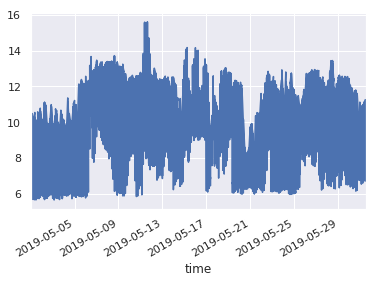

In [6]:
df.ctdpf_ckl_seawater_temperature.plot();               

But what if we want to change how we plot the data?  For this, we need to use Matplotlib's plotting functions so we can specify both the x and y axes independently.

Let's plot the temperature data vs. pressure.

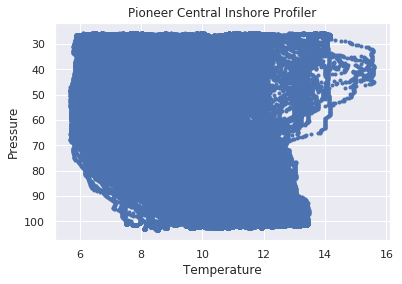

In [7]:
plt.plot(df.ctdpf_ckl_seawater_temperature,df.ctdpf_ckl_seawater_pressure, linestyle='',marker='.');

# Flip the y-axis
ax = plt.gca()
ax.invert_yaxis()

# Label the Plot
plt.ylabel('Pressure')
plt.xlabel('Temperature');
plt.title('Pioneer Central Inshore Profiler');

This is kind of a crazy plot, because we're plotting an entire month of temperature profiles.

Instead, let's create a profile timeseries plot, which is sometimes called a [Hovmoller](https://en.wikipedia.org/wiki/Hovmöller_diagram) diagram.

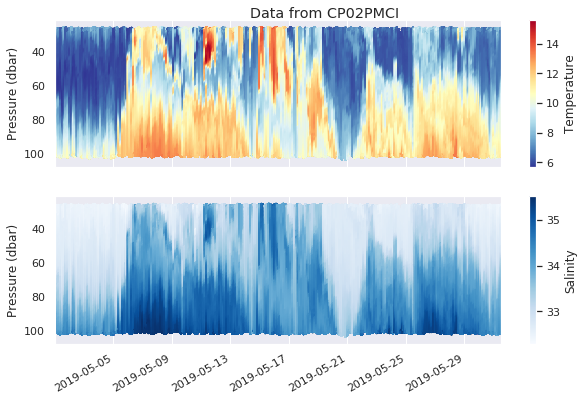

In [8]:
# Scatterplots of Temperature and Salinity
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,6))

sc1 = ax1.scatter(df.index, df.ctdpf_ckl_seawater_pressure, c=df.ctdpf_ckl_seawater_temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(df.index, df.ctdpf_ckl_seawater_pressure, c=df.practical_salinity, cmap='Blues', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(df.index[0],df.index[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')

fig.suptitle('Data from %s' % ds.subsite)
fig.autofmt_xdate()
fig.subplots_adjust(top=0.95);


This is a very interesting dataset, and certainly not something you see in a textbook.  There's a lot of cool oceanography going on in the Pioneer Array.

## Glider Data
Working with glider data requires a few extra steps.  Let's take a look at an Irminger Glider dataset

In [0]:
# Irmginer Glider Dissolved Oxygen & CTD
datafile = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sage@marine.rutgers.edu/20190509T152634-GI05MOAS-PG528-02-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered/deployment0001_GI05MOAS-PG528-02-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered_20150817T144410.956600-20160530T193951.630430.nc'

In [10]:
# Load the data files
ds = xr.open_dataset(datafile)
ds = ds.swap_dims({'obs': 'time'}) #Swap dimensions
print('Dataset has %d points' % ds.time.size)
# And convert to a Pandas DataFrame - This can take a while with a lot of points
df = ds.to_dataframe()

Dataset has 628560 points


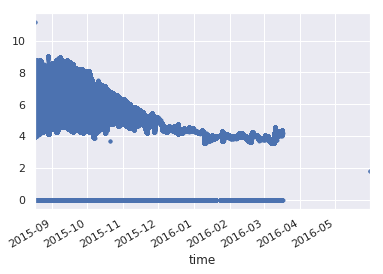

In [11]:
# A quick plot of temperature
df.sci_water_temp.plot(linestyle='',marker='.');

It turns out that gliders (for annoying historical reasons) use 0 as a fill value.  We can use the following code to eliminate those rows.

In [0]:
df = df.where(df.practical_salinity>0)

It also turns out that this dataset has some outliers.  If you try to run the scatterplot code below, or if you plot individual variables, you will discover...
* One point has a salinity value of around 5, when everything should be closer to 35
* One point has a pressure value of 944, but the glider only goes to about 150m
* The last 3 points are dated 5/30, but the last usable data is from 3/17

In [0]:
# Add code here to investigate these outliers using plot, hist, or describe

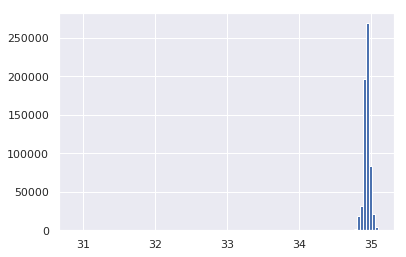

In [14]:
# For example
df.practical_salinity.where(df.practical_salinity>30).hist(bins=100)

We can filter out these outliers using the following code.  

Alternatively, we could always just specify axes limits when creating our plots, which wouldn't require changing the dataset.

In [0]:
# Filter out data after 3/18
df = df.loc[:'2016-03-18'] 

# Filter out data where pressure is greater than 200
df = df.where(df.int_ctd_pressure<200) 

# Filter out data where salinity 
df = df.where(df.practical_salinity>34) 

Now we can make a nice profile timeseries plot.

Notice the vmin/vmax flags in the scatterplot line to specify the colorbar limits to a narrower range.

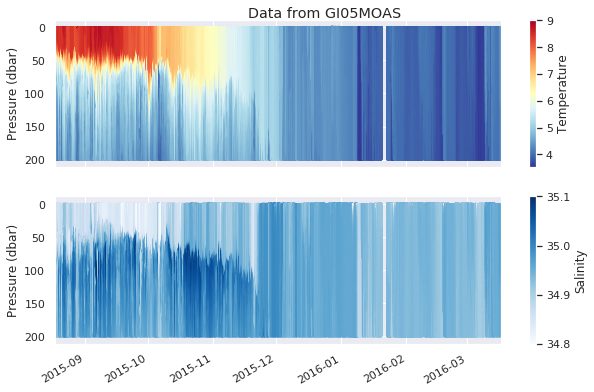

In [16]:
# Scatterplots of Temperature and Salinity
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,6))

sc1 = ax1.scatter(df.index, df.int_ctd_pressure, c=df.sci_water_temp, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(df.index, df.int_ctd_pressure, c=df.practical_salinity, cmap='Blues', s=2, vmin=34.8, vmax=35.1)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(df.index[0],df.index[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')

fig.suptitle('Data from %s' % ds.subsite)
fig.autofmt_xdate()
fig.subplots_adjust(top=0.95);
